# WP2 with GPR 4

This is the application of "real" Gaussian Process Regression (GPR) = sparse GPR, as opposed to "full" GPR, as described in Deringer2021. For this, we need to choos a representative set of $M < N$ samples. This is done with the CUR decomposition, as shown in ML Tutorial 1 > Deringer2021.

For featurization, models and sparsification, we use the implementations provided in the packages scikit-cosmo and librascal (`skcosmo`, `rascal`).

Such sparsification methods can also be viewed as feature space dimension reduction techniques. We might also try Farthest Point Sampling (FPS) for sample selection and feature selection.

Changelog:

- 2023-01-30: copied [rascal docs > A Gaussian approximation potential (GAP) for the Zundel cation](https://lab-cosmo.github.io/librascal/examples/zundel_i-PI.html) with minor adjustments. First attempt with `train_gap_model` failed numerically. Probably cause I misuse a PES model (energy+forces) for Jij prediction (no forces / gradients available). Try with `rascal.models.KRR` next.
- 2023-01-30: try `deringer2021-water.ipynb` as template next.
- 2023-01-30: Also failed, problem is that rascal SOAP featurizes each structure as full SOAP = all atoms get a feature vector. Then the shape of `X` is much too large, the resulting kernel matrix as well instead of being of shape `num_samples X num_samples`. Dunno how to fix that, found no `SphericalInvariants` method so fa to specify to produce only one feature vector per structure.
- 2023-01-30: Try again, but this time with `X` produced with DSCribe SOAP.
- 2023-01-30: Worked!
- 2023-02-12: wp2-with-gpr4: Try out different SOAP parameter settings (X -> X1,X2,X3). No hyperopt yet.

# References

Code refs.

- [librascal repo](https://github.com/lab-cosmo/librascal)
- [librascal docs](https://lab-cosmo.github.io/librascal/)
  - [rascal docs > Python API](https://lab-cosmo.github.io/librascal/reference/python.html). Representations, Models, Filters, etc.
  - [rascal docs > Fitting a model with librascal](https://lab-cosmo.github.io/librascal/user_guide/model_fitting.html)
  - [rascal docs > A Gaussian approximation potential (GAP) for the Zundel cation](https://lab-cosmo.github.io/librascal/examples/zundel_i-PI.html). Example of a KKR (sparse GPR via CUR decomposition) model, plus model assessment.
  - [rascal docs > Using feature selection to build an efficient potential](https://lab-cosmo.github.io/librascal/examples/Feature_selection_example.html). Example of a KRR (sparse GPR via FPS) model, plus model assessment, including guide for "How do we know how many features to select?".
  - [rascal docs > SOAP theory](https://lab-cosmo.github.io/librascal/SOAP.html)
  
- [scikit-cosmo docs](https://scikit-cosmo.readthedocs.io)
  - [skcosmo docs > API > Feature and sample selection](https://scikit-cosmo.readthedocs.io/en/latest/selection.html). CUR, FPS, and PCov extensions.
  - [skcosmo docs > Examples](https://scikit-cosmo.readthedocs.io/en/latest/tutorials.html)
    - "Feature and Sample Selection"
      - [Using scikit-COSMO selectors with scikit-learn pipelines](https://scikit-cosmo.readthedocs.io/en/latest/read-only-examples/Selectors-Pipelines.html)
  - [skcosmo docs > API > PCovR](https://scikit-cosmo.readthedocs.io/en/latest/pcovr.html). PCovR and KPCovR.
  - [skocsmo docs > API > GRE](https://scikit-cosmo.readthedocs.io/en/latest/gfrm.html)
  
  
Literature refs.

- [Deringer2021](https://doi.org/10.1021/acs.chemrev.1c00022). "Gaussian Process Regression for Materials and Molecules".
  - [Tutorial repository](https://github.com/gabor1/chemrev-gpr). This notebook [is copied](https://github.com/gabor1/chemrev-gpr/blob/main/water/water.ipynb) from there.
- [Cersonsky2021](https://doi.org/10.1088/2632-2153/abfe7c). CUR, FPS, and PCov extensions.

## Imports

In [1]:
# ipython magic autoreload for code development: 
# makes code changes in any imported code available instantly.
# avoid having to restart the notebook kernel.
%load_ext autoreload
%autoreload 2

In [2]:
# Python imports
import sys
import os
from pathlib import Path

In [3]:
# ase imports
import ase.io
import ase.visualize

In [4]:
# packages imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)
from time import time

In [5]:
# dscribe imports
import dscribe.descriptors
import dscribe.kernels
import dscribe.utils

In [6]:
# skcosmo imports
import skcosmo.utils
import skcosmo.preprocessing
import skcosmo.sample_selection
import skcosmo.feature_selection
import skcosmo.decomposition
import skcosmo.linear_model
import skcosmo.model_selection
import skcosmo.metrics

In [7]:
# rascal imports
import rascal.utils
import rascal.neighbourlist
import rascal.representations
import rascal.models

In [8]:
# sklearn imports
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.pipeline
import sklearn.metrics

In [9]:
# project imports
import sisclab22p6.plotting
import sisclab22p6.data
import sisclab22p6.features
import sisclab22p6.features_plotters
import sisclab22p6.target_plotters

# Load data

In [10]:
filepath_data = "../../../../data/jij"
filename_table = "d_block_magnetic_data_modified.csv"
filename_structures = "dimer_clusters.extxyz"

In [11]:
table = sisclab22p6.data.load_jij_data(filepath=filepath_data,
                                       filename_structures=filename_structures,
                                       filename_table=filename_table)

Loaded Number samples: 1730, 1730.


In [12]:
table = table.drop_duplicates('workchain_label')

In [13]:
n_samples = table.shape[0]

In [14]:
structures =  list(table.structure)

In [15]:
jijs = list(table.J)

In [16]:
global_species = sisclab22p6.features.get_chemical_species(structures)

In [17]:
defect_atoms_positions = sisclab22p6.features.get_defect_atoms_positions(structures)

In [18]:
atoms_distance_statistics = sisclab22p6.features.get_atom_distance_statistics(structures, atom_idx=0)

Atom distance statistics, measured from atom at index 0.
For the structures with n_atoms=12:
count distances to atom 0: 400
min distances to atom 0: [3.030 3.030 3.030 3.246 3.246 3.246 4.383 6.899 5.328 6.997 5.454]
max distances to atom 0: [3.030 3.030 3.030 3.246 3.246 3.246 4.383 6.899 5.328 6.997 5.454]
mean distances to atom 0: [3.030 3.030 3.030 3.246 3.246 3.246 4.383 6.899 5.328 6.997 5.454]
For the structures with n_atoms=14:
count distances to atom 0: 1328
min distances to atom 0: [3.030 3.030 3.030 3.246 3.246 3.246 6.097 5.102 5.102 5.102 6.997 6.997
 5.454]
max distances to atom 0: [3.030 3.030 3.030 3.246 3.246 3.246 13.149 15.482 14.344 13.493 15.526
 13.703 14.365]
mean distances to atom 0: [3.030 3.030 3.030 3.246 3.246 3.246 7.795 8.084 7.164 6.870 9.935 8.970
 8.927]


# Hyperopt

TODO. For now, without hyperopt.

# Featurization

In [19]:
soap_params_template = dict(
    r_cut='template',
    n_max='template',
    l_max='template',
    sigma='template',
    rbf='gto',
    weighting=None,
    crossover=True,
    average='inner',
    species=global_species,
    periodic=False,
    sparse=False,
    dtype='float64'
)

In [20]:
soap_params1 = soap_params_template.copy()
soap_params1.update(dict(
    r_cut=2.0,
    n_max=7,
    l_max=6,
    sigma=0.75
))

soap_params2 = soap_params_template.copy()
soap_params2.update(dict(
    r_cut=4.0,
    n_max=7,
    l_max=6,
    sigma=0.75
))

soap_params3 = soap_params_template.copy()
soap_params3.update(dict(
    r_cut=16.0,
    n_max=7,
    l_max=6,
    sigma=0.75
))

In [21]:
soap1 = dscribe.descriptors.SOAP(**soap_params1)
soap2 = dscribe.descriptors.SOAP(**soap_params2)
soap3 = dscribe.descriptors.SOAP(**soap_params3)

In [22]:
print(soap1.get_number_of_features())
print(soap2.get_number_of_features())
print(soap3.get_number_of_features())

76146
76146
76146


In [23]:
X1 = soap1.create(system=structures,                 
                 positions=defect_atoms_positions,
                 n_jobs=-1,
                 verbose=True)
X2 = soap2.create(system=structures,                 
                 positions=defect_atoms_positions,
                 n_jobs=-1,
                 verbose=True)
X3 = soap3.create(system=structures,                 
                 positions=defect_atoms_positions,
                 n_jobs=-1,
                 verbose=True)

In [24]:
Xs = [X1, X2, X3]
[X.shape for X in Xs]

[(1728, 76146), (1728, 76146), (1728, 76146)]

# Build model

In [25]:
XXTs = []
for X in Xs:
    start = time()
    XXTs.append(X@X.T)
    print ("Execution: ", time()-start, "s", ", shape ", XXTs[-1].shape)

Execution:  0.6480786800384521 s , shape  (1728, 1728)
Execution:  0.6251897811889648 s , shape  (1728, 1728)
Execution:  0.6372833251953125 s , shape  (1728, 1728)


In [26]:
klins = []
nrms = []
gammas = []
kgausss = []
kgopts = []

for X, XXT in zip(Xs, XXTs):

    # build different kernel matrices: linear, Gauss, "Gauss optimized"
    klin = (XXT)**1
    nrm = (X**2).sum(axis=1)
    gamma = 1.0/(2*1e-1**2)
    kgauss = np.exp(-(np.add.outer(nrm,nrm) - 2*XXT)*gamma)
    kgopt = np.exp(-(np.add.outer(nrm,nrm) - 2*XXT)*0.5/(1**2))
    #marg = kgauss.sum(axis=1);
    #kgauss += marg.sum()/len(marg)**2 - np.add.outer(marg,marg)/len(marg)

    klins.append(klin)
    nrms.append(nrm)
    gammas.append(gamma)
    kgausss.append(kgauss)
    kgopts.append(kgopt)

In [27]:
[gamma for gamma in gammas]

[49.99999999999999, 49.99999999999999, 49.99999999999999]

Observation kernel matrices plots:
- For SOAP n,l=7,6, sigma=[0.1, 0.5, 10], klin gets sparser->denser, while kgauss gets dense->sparser

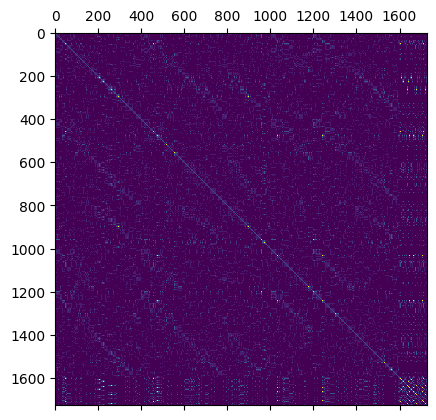

In [28]:
plt.matshow(klins[0])

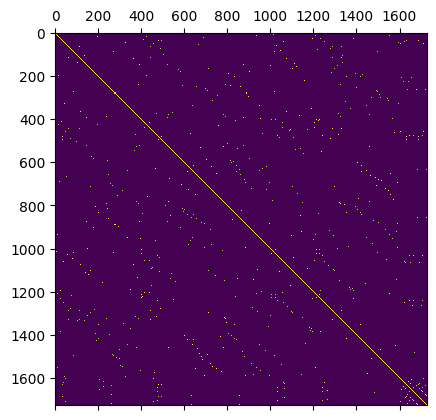

In [29]:
plt.matshow(kgausss[0])

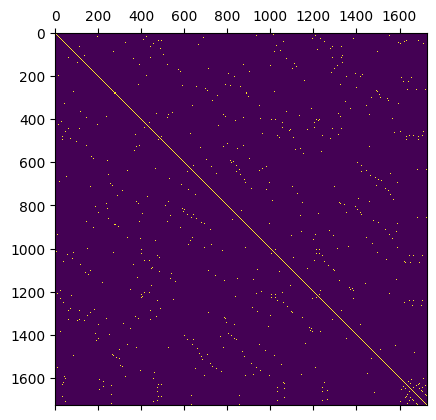

In [30]:
plt.matshow(kgopts[0])

# Train-test split, and regress

In [31]:
y = np.array(jijs)
global_num_samples = len(jijs)
global_num_samples

1728

In [32]:
# Number of structures to train the model with
train_test_split = 0.2
num_samples_train = int((1-train_test_split) * global_num_samples)

# Select randomly n structures for training the model
ids = list(range(global_num_samples))
np.random.seed(10)
np.random.shuffle(ids)

train_ids = ids[:num_samples_train]
test_ids = ids[num_samples_train:]
structures_train = [structures[ii] for ii in ids[:num_samples_train]]
y_train = [jijs[ii] for ii in ids[:num_samples_train]]
y_train = np.array(y_train)

In [33]:
itrain = train_ids
itest = test_ids
ntot = global_num_samples

In [34]:
klins[0][itrain][0,:].shape

(1728,)

In [35]:
# "training": solve for model coefficients / weights as K * w = y. So, kernel ridge regression.

# some comment on the index slicing in the training. the K matrices have shape n_samples x n_samples.
#
# the index list itrain is a random, unsorted list of integers i, i in [0, n_samples], 
# of length n_train = (1 - train_test_split) * n_samples, n_train < n_samples.
# 
# the expression K[itrain][:,itrain], therefore, works like this:
# K[itrain] = pick out the random, itrain rows from K. K[itrain].shape = n_train x n_samples.
# The expression K[itrain] is a nex matrix. So, the second slicing operator just performs row-column slicing 
# on this new matrix.
#
# Therefore, K[itrain][0,:] picks out the first row of K[itrain], of length n_samples, shape (n_samples,).
# While K[itrain][:,0] picks out the first column of K[itrain], of length n_train, shape (n_train,).
#
# Likewise, then, K[itrain][:,itrain] picks out n_train columns from the K[itrain] matrix.
# So that, in the end, we get an n_train x n_train size matrix.
# What at first may seem odd, but is perfectly reasonable, is that the slicing by itrain is random access, 
# ie, first K[itrain] rearranges the order of the rows, then K[itrain][:,itrain] rearranges the order of the 
# columns.
# 
# For the next section, let's rename K[itrain][:,itrain] := K_train.
#
# The KRR "training" is just solving the linear system A * w = b, by w = least_squares(A, b), with 
# LHS = RHS <==> A * w = b <==> (K_train + lamda * 1_train) * w = y_train.
#
# The resulting weight vector, therefore, has length n_train.
#
# Side notes:
#
# - iset := random index subset. Then, A[is][:,is]**2 is the same as (A**2)[is][:,is].
#

lamda = 1e-8 # regularization (lambda is a Python keyword)
wlins = []
wquads = []
wgausss = []
wgopts = []
for klin, kgauss, kgopt in zip(klins, kgausss, kgopts):
    wlin =   np.linalg.lstsq( klin[itrain][:,itrain]    + lamda*np.eye(len(itrain)), y[itrain], rcond=None)[0]
    wquad =  np.linalg.lstsq( klin[itrain][:,itrain]**2 + lamda*np.eye(len(itrain)), y[itrain], rcond=None)[0]
    wgauss = np.linalg.lstsq( kgauss[itrain][:,itrain]  + lamda*np.eye(len(itrain)), y[itrain], rcond=None)[0]
    wgopt =  np.linalg.lstsq( kgopt[itrain][:,itrain]   + lamda*np.eye(len(itrain)), y[itrain], rcond=None)[0]
    
    wlins.append(wlin)
    wquads.append(wquad)
    wgausss.append(wgauss)
    wgopts.append(wgopt)

In [36]:
wlins[0].shape, wquads[0].shape, wgausss[0].shape, wgopts[0].shape

((1382,), (1382,), (1382,), (1382,))

In [37]:
# define dataset sizes
n_samples = len(y)
n_train = len(itrain)
n_test = n_samples - n_train
n_samples, n_train, n_test

(1728, 1382, 346)

In [38]:
# # model weights = regression coefficients
# weights = {K_name : None for K_name in kernel_matrices.keys()}

# # regularization term
# R = lamda * np.eye(n_train)

# # perform the KRR regression / model "training"
# for K_name, K in kernel_matrices.items():
    
#     # slice out the n_train^2 training matrix from the full n_samples^2 kernel matrix
#     # itrain specifies the rows and columns to be sliced out
#     K_train = kernel[itrain][:,itrain]

#     # solve the linear system
#     A = K_train + R
#     b = y_train
#     w = np.linalg.lstsq(A, b, rcond=None)
    
#     # store the weights
#     weights[K_name] = w

In [39]:
# free up some memory
del X, X1, X2, X3, Xs, XXT, XXTs

In [40]:
# prediction with linear kernel, quadratic kernel, gauss kernel, optimized gauss kernel
ypred_lins = []
for klin, wlin, in zip(klins, wlins):
    ypred_lin   = klin[:,itrain]      @ wlin
    ypred_lins.append(ypred_lin)

ypred_quads = []    
for klin, wquad in zip(klins, wquads):        
    ypred_quad  = (klin[:,itrain]**2) @ wquad
    ypred_quads.append(ypred_quad)    

ypred_gausss = []   
for kgauss, wgauss in zip(kgausss, wgausss):    
    ypred_gauss = (kgauss[:,itrain])  @ wgauss
    ypred_gausss.append(ypred_gauss)

ypred_gopts = []
for kgopt, wgopt in zip(kgopts, wgopts):    
    ypred_gopt  = (kgopt[:,itrain])   @ wgopt
    ypred_gopts.append(ypred_gopt)

In [41]:
for i in range(len(ypred_lins)):
    print(ypred_lins[i].shape, ypred_quads[i].shape, ypred_gausss[i].shape, ypred_gopts[i].shape)

(1728,) (1728,) (1728,) (1728,)
(1728,) (1728,) (1728,) (1728,)
(1728,) (1728,) (1728,) (1728,)


In [42]:
# RMSE of opt. gaussian kernel prediction
for ypred_gopt in ypred_gopts:
    print(np.sqrt(np.mean((ypred_gopt - y)[itest]**2)))

1.7678672017221067
1.4173537950062578
1.4334063114845284


In [43]:
# MAEs
mae_lins = []
mae_quads = []
mae_gausss = []
mae_gopts = []

for ypred_lin, ypred_quad, ypred_gauss, ypred_gopt in zip(ypred_lins, ypred_quads, ypred_gausss, ypred_gopts):
    mae_lin = sklearn.metrics.mean_absolute_error(y,ypred_lin)
    mae_quad = sklearn.metrics.mean_absolute_error(y,ypred_quad)
    mae_gauss = sklearn.metrics.mean_absolute_error(y,ypred_gauss)
    mae_gopt = sklearn.metrics.mean_absolute_error(y,ypred_gopt)
    
    mae_lins.append(mae_lin)
    mae_quads.append(mae_quad)
    mae_gausss.append(mae_gauss)
    mae_gopts.append(mae_gopt)

print('maes, rows=soap1-3, columns=klin,kquad,kgauss,kgopt')
for mae_lin, mae_quad, mae_gauss, mae_gopt in zip(mae_lins, mae_quads, mae_gausss, mae_gopts):    
    print(mae_lin, mae_quad, mae_gauss, mae_gopt)

maes, rows=soap1-3, columns=klin,kquad,kgauss,kgopt
0.2774131916924177 0.23972883617185559 0.2470158155265294 0.24710529251754
0.395749519196658 0.5223752406809169 0.11153731966195836 0.11070878105727575
0.09879230141180219 0.08647223108375492 0.07484704633814342 0.07519237869819785


In [44]:
# R2 coefficient of determination
r2_lins = []
r2_quads = []
r2_gausss = []
r2_gopts = []

for ypred_lin, ypred_quad, ypred_gauss, ypred_gopt in zip(ypred_lins, ypred_quads, ypred_gausss, ypred_gopts):
    r2_lin = sklearn.metrics.r2_score(y,ypred_lin)
    r2_quad = sklearn.metrics.r2_score(y,ypred_quad)
    r2_gauss = sklearn.metrics.r2_score(y,ypred_gauss)
    r2_gopt = sklearn.metrics.r2_score(y,ypred_gopt)
    
    r2_lins.append(r2_lin)
    r2_quads.append(r2_quad)
    r2_gausss.append(r2_gauss)
    r2_gopts.append(r2_gopt)

print('r2s, rows=soap1-3, columns=klin,kquad,kgauss,kgopt')
for r2_lin, r2_quad, r2_gauss, r2_gopt in zip(r2_lins, r2_quads, r2_gausss, r2_gopts):    
    print(r2_lin, r2_quad, r2_gauss, r2_gopt)

r2s, rows=soap1-3, columns=klin,kquad,kgauss,kgopt
0.9478329302568231 0.9220328204910648 0.8891094499308915 0.8889533008884065
-0.879544152264141 -11.788609440700458 0.9381665739404782 0.9406498986952988
0.9569682696557926 0.9741412354770155 0.9424936360028437 0.9424786641700156


In [45]:
(ypred_gausss[0]-y)[itrain]

array([0.000, -0.009, -0.001, ..., -0.000, -0.123, 0.000])

In [78]:
label_lins = [
    "$r_{cut}=2 \mathrm{\AA} \ k_{lin}$",
    "$r_{cut}=4 \quad k_{lin}$",
    "$r_{cut}=16 \ k_{lin}$",
]
label_quads = [
    "$r_{cut}=2 \quad k_{quad}$",
    "$r_{cut}=4 \quad k_{quad}$",
    "$r_{cut}=16 \, k_{quad}$",
]
label_gausss = [
    "$r_{cut}=2 \quad k_{rbf}$",
    "$r_{cut}=4 \quad k_{rbf}$",
    "$r_{cut}=16 \ k_{rbf}$",
]
label_gopts = [
    "$r_{cut}=2 \quad k_{rbfo}$",
    "$r_{cut}=4 \quad k_{rbfo}$",
    "$r_{cut}=16 \ k_{rbfo}$",
]

In [65]:
from cycler import cycler
default_cycler = (cycler(color=['r', 'g', 'b', 'y']) +
                  cycler(linestyle=['-', '--', ':', '-.']))
custom_cycler = (cycler(color=['c', 'm', 'y', 'k']) +
                 cycler(lw=[1, 2, 3, 4]))

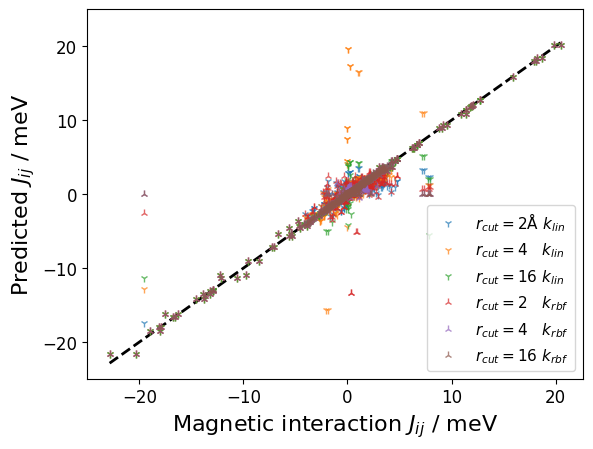

In [79]:
fontsize=16
fontsize_legend=11
fontsize_ticks=12

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
for ypred_lin, label_lin in zip(ypred_lins, label_lins):
    plt.plot(y, ypred_lin, '1', label=label_lin, alpha=0.7)
# for ypred_quad, label_quad in zip(ypred_quads, label_quads):
#     plt.plot(y, ypred_quad, '4', label=label_quad, alpha=0.7)
for ypred_gauss, label_gauss in zip(ypred_gausss, label_gausss):
    plt.plot(y, ypred_gauss, '2', label=label_gauss, alpha=0.7)
# for ypred_gopt, label_gopt in zip(ypred_gopts, label_gopts):
#     plt.plot(y, ypred_gopt, '3', label=label_gopt, alpha=0.7)    

plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.xlabel('Magnetic interaction $J_{ij}$ / meV', fontsize=fontsize)
plt.ylabel('Predicted $J_{ij}$ / meV', fontsize=fontsize)
plt.ylim(bottom=-25,top=25)
plt.legend(fontsize=fontsize_legend, loc=4)
plt.savefig("fig/soap-krr_parity-plot_soap-rcut-2-to-16-k-lin-to-gopt-gamma-50.pdf", transparent=True)

In [96]:
label_lin = r"$k=x\cdot x'$"
label_quad = r"$k=(x\cdot x')^2$"
label_gauss = r"$k=exp(-\frac{|x-x'|^2}{2\theta^2})$"

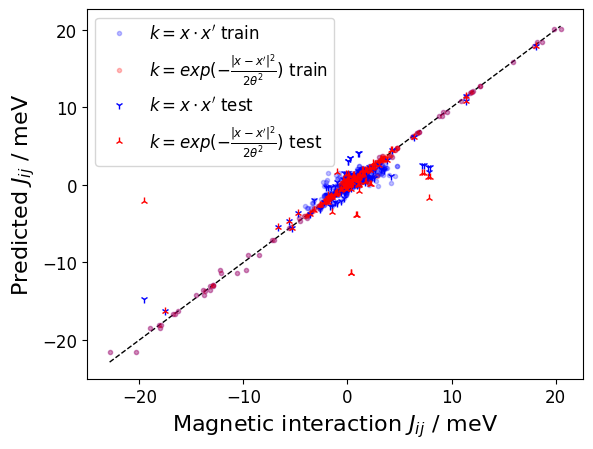

In [97]:
ypred_z1 = ypred_lins[1]
ypred_g = ypred_gausss[1]
label_z1 = label_lin
label_g = label_gauss

fontsize=16
fontsize_legend=12
fontsize_ticks=12
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
plt.plot(y[itrain], ypred_z1[itrain], 'b.', label=f"{label_z1} train", alpha=0.25)
plt.plot(y[itrain], ypred_g[itrain], 'r.', label=f"{label_g} train", alpha=0.25)
plt.plot(y[itest], ypred_z1[itest], 'b1', label=f"{label_z1} test")
plt.plot(y[itest], ypred_g[itest], 'r2', label=f"{label_g} test")
# # plt.plot(ypred_z2[itest], y[itest], 'k+', label='z2 test')
# plt.plot(ypred_gopt[itest], y[itest], 'g3', label='gopt test')

plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.xlabel('Magnetic interaction $J_{ij}$ / meV', fontsize=fontsize)
plt.ylabel('Predicted $J_{ij}$ / meV', fontsize=fontsize)
plt.legend(fontsize=fontsize_legend)
# plt.savefig("fig/soap-krr_parity-plot_soap-r4.0-n4-l4-s0.5_kr-gamma-40.pdf", transparent=True)

# Parity heatmap

In [47]:
# "training": solve for model coefficients / weights as K * w = y. So, kernel ridge regression.
lamda = 1e-8 # regularization (lambda is a Python keyword)
w1 = np.linalg.lstsq( kernel    + lamda*np.eye(len(y)), y, rcond=None)[0]
w2 = np.linalg.lstsq( kernel**2 + lamda*np.eye(len(y)), y, rcond=None)[0]
wg = np.linalg.lstsq( kgauss    + lamda*np.eye(len(y)), y, rcond=None)[0]
wgopt = np.linalg.lstsq( kgopt  + lamda*np.eye(len(y)), y, rcond=None)[0]

In [48]:
# prediction with linear kernel, quadratic kernel, gauss kernel, optimized gauss kernel
ypred_z1 = kernel @ w1
ypred_z2 = (kernel**2) @ w2
ypred_g = (kgauss) @ wg
ypred_gopt = (kgopt) @ wgopt

In [92]:
# plot Jij "parity heatmap", on all data (X has same row order as table -> no ID re-matching needed!)
# MAE = sum(abs(y - ypred))/len(y)
y_signed_err_z1 = y - ypred_z1 # linear kernel
y_signed_err_g = y - ypred_g # gaussian kernel
y_abs_err_z1 = abs(y - ypred_z1) # linear kernel
y_abs_err_g = abs(y - ypred_g) # gaussian kernel

In [93]:
# create heatmaps
heatmap_matrix_ypred_z1, missing_defect_pairs = sisclab22p6.target_plotters.create_heatmap_matrix(table, value_array=ypred_z1)
heatmap_matrix_ypred_g, missing_defect_pairs = sisclab22p6.target_plotters.create_heatmap_matrix(table, value_array=ypred_g)
heatmap_matrix_signed_err_z1, missing_defect_pairs = sisclab22p6.target_plotters.create_heatmap_matrix(table, value_array=y_signed_err_z1)
heatmap_matrix_signed_err_g, missing_defect_pairs = sisclab22p6.target_plotters.create_heatmap_matrix(table, value_array=y_signed_err_g)
heatmap_matrix_abs_err_z1, missing_defect_pairs = sisclab22p6.target_plotters.create_heatmap_matrix(table, value_array=y_abs_err_z1)
heatmap_matrix_abs_err_g, missing_defect_pairs = sisclab22p6.target_plotters.create_heatmap_matrix(table, value_array=y_abs_err_g)

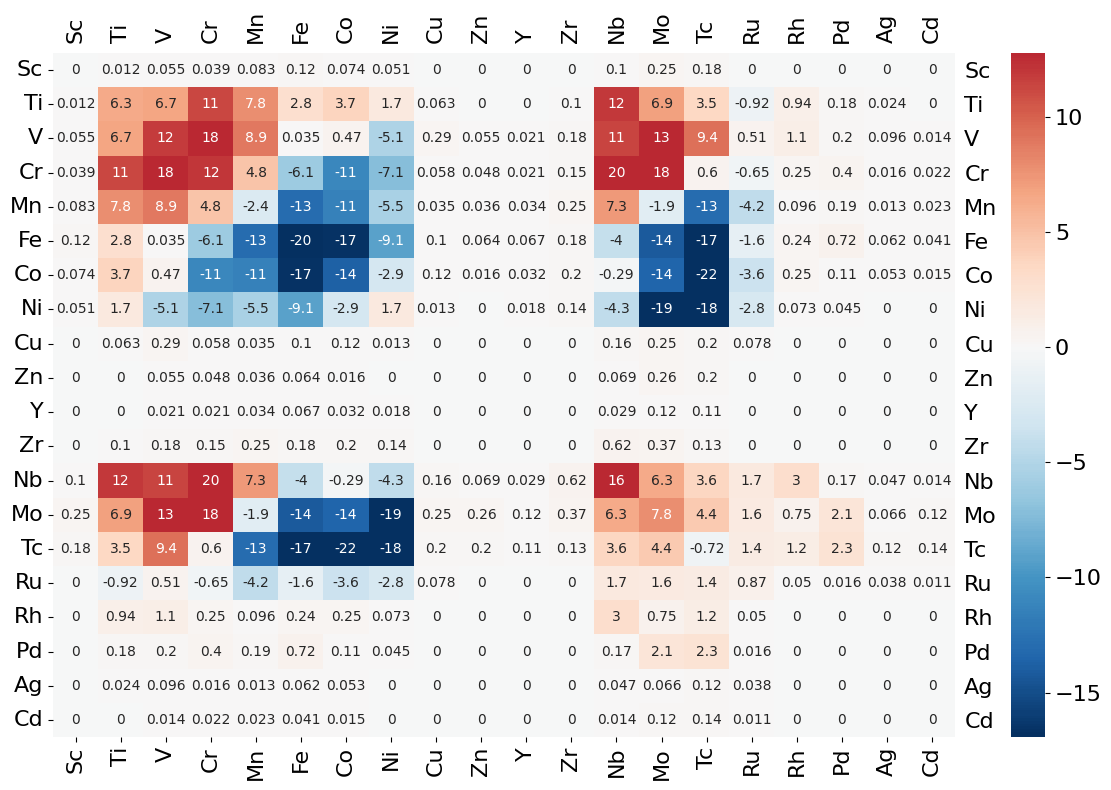

In [94]:
# plot ypred, linear kernel
sisclab22p6.target_plotters.plot_heatmap(heatmap_matrix_ypred_z1, publication_target='slides', fontsize='small')
plt.savefig('fig/heatmap-jij-predicted-linear-kernel.pdf')

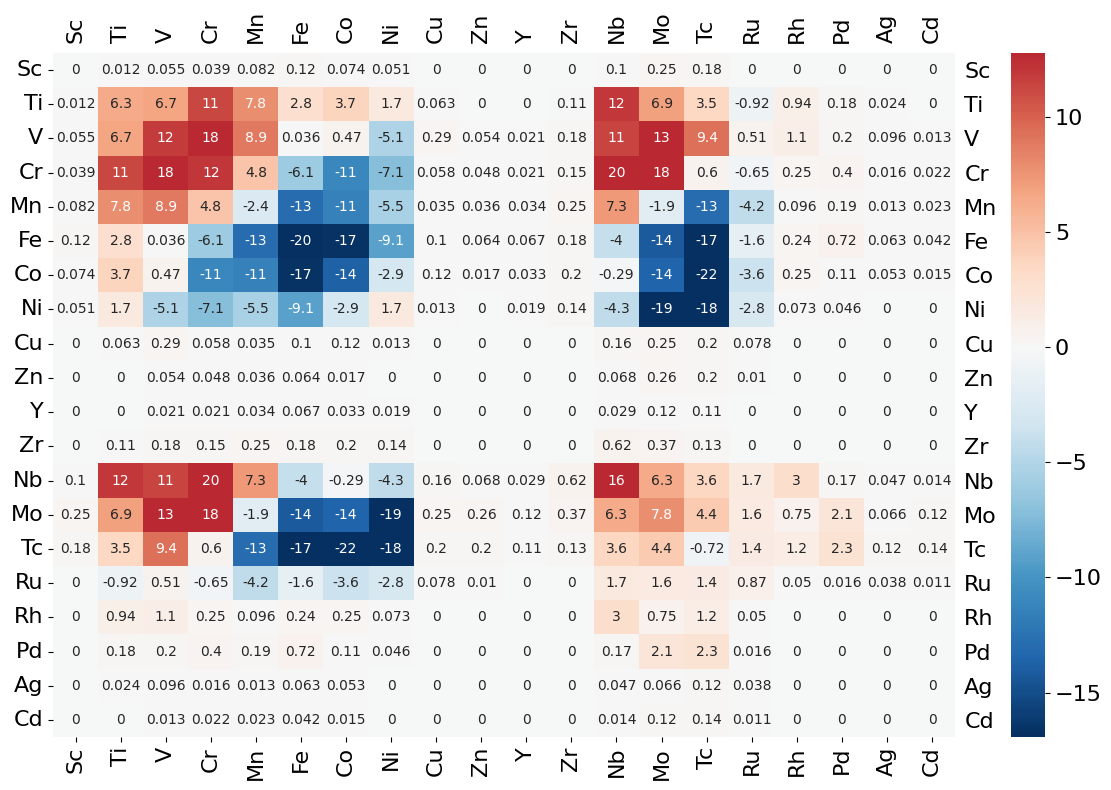

In [95]:
# plot ypred, gaussian kernel
sisclab22p6.target_plotters.plot_heatmap(heatmap_matrix_ypred_g, publication_target='slides', fontsize='small')
plt.savefig('fig/heatmap-jij-predicted-gaussian-kernel.pdf')

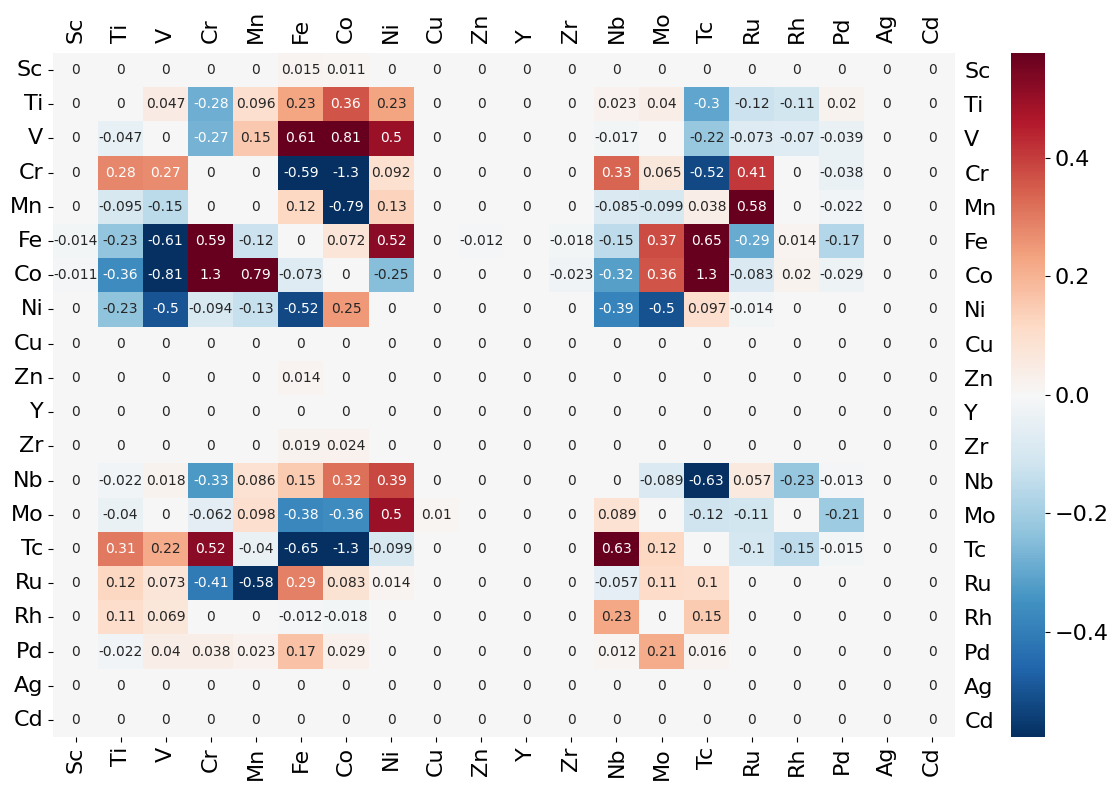

In [96]:
# plot signed error, linear kernel
sisclab22p6.target_plotters.plot_heatmap(heatmap_matrix_signed_err_z1, publication_target='slides', fontsize='small')
plt.savefig('fig/heatmap-jij-signed-err-y-minus-ypred-linear-kernel.pdf')

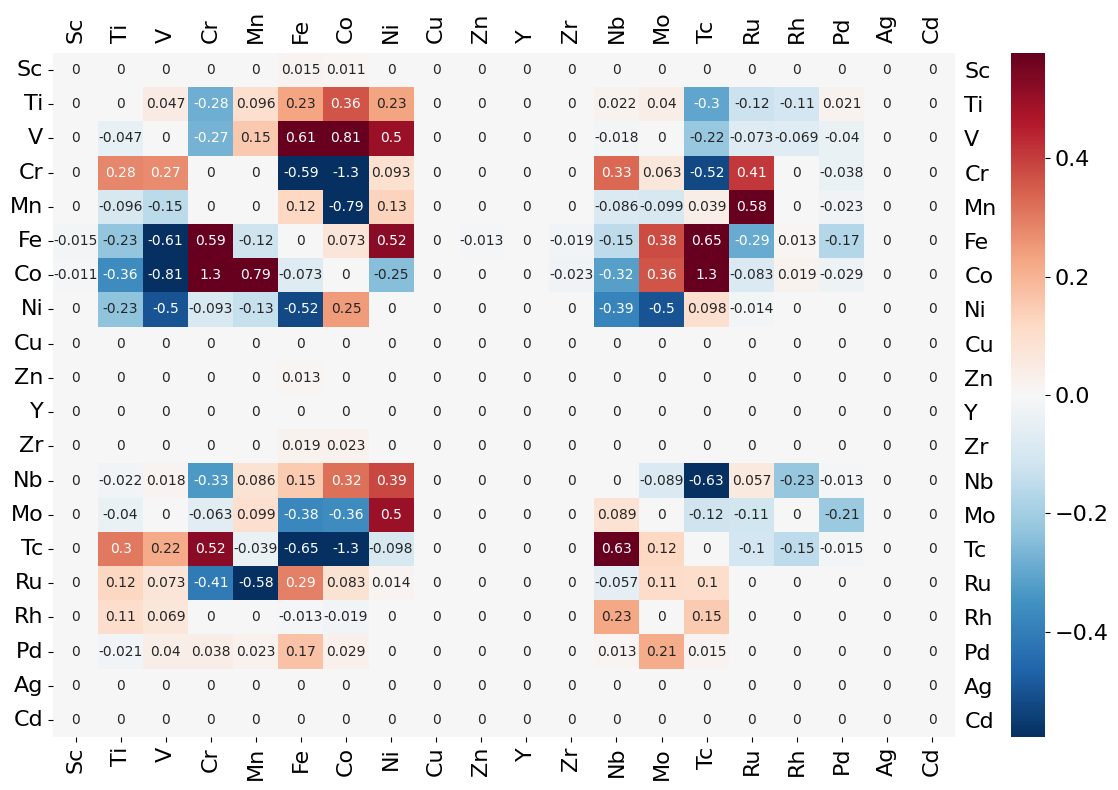

In [97]:
# plot signed error, gaussian kernel
sisclab22p6.target_plotters.plot_heatmap(heatmap_matrix_signed_err_g, publication_target='slides', fontsize='small')
plt.savefig('fig/heatmap-jij-signed-err-y-minus-ypred-gaussian-kernel.pdf')

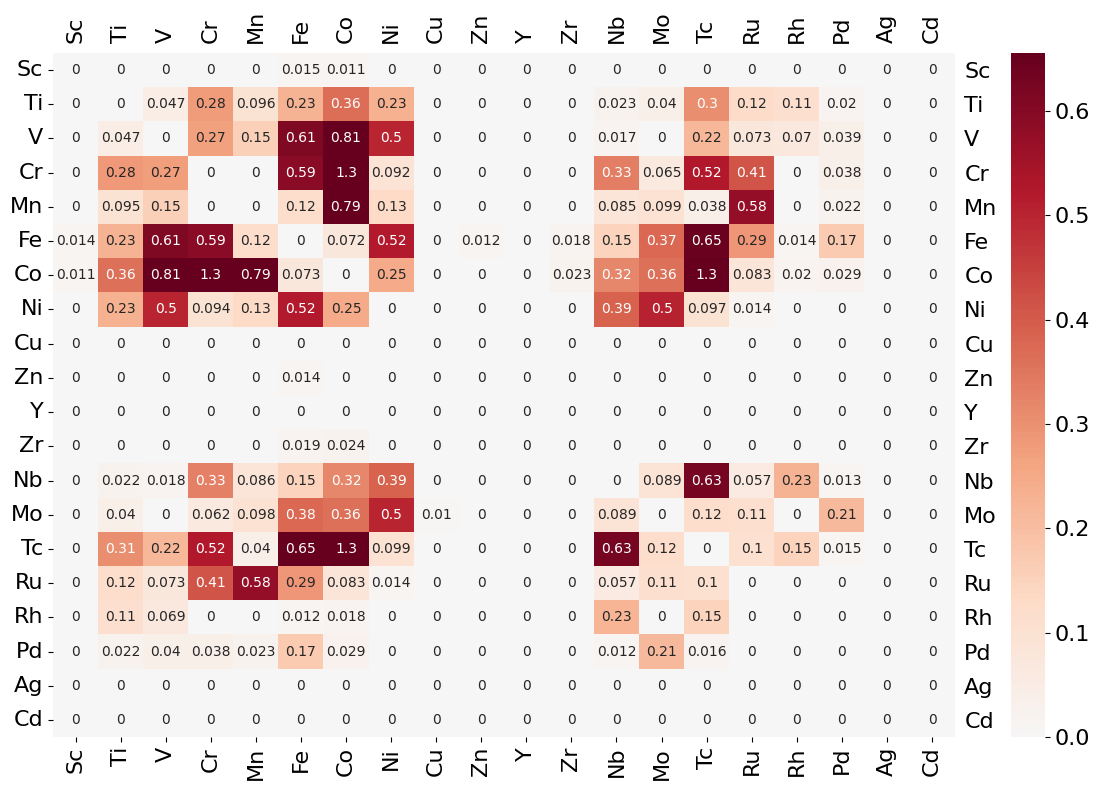

In [98]:
# plot absolute error, linear kernel
sisclab22p6.target_plotters.plot_heatmap(heatmap_matrix_abs_err_z1, publication_target='slides', fontsize='small')
plt.savefig('fig/heatmap-jij-abs-err-linear-kernel.pdf')

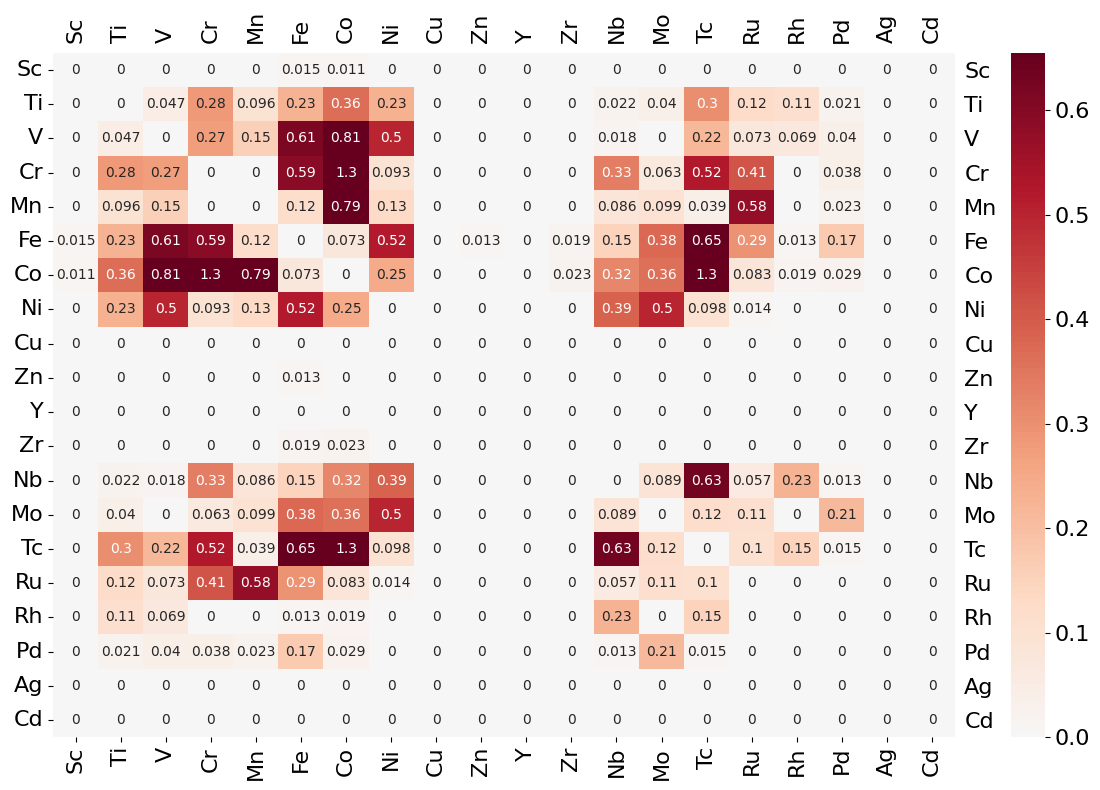

In [99]:
# plot absolute error, linear kernel
sisclab22p6.target_plotters.plot_heatmap(heatmap_matrix_abs_err_g, publication_target='slides', fontsize='small')
plt.savefig('fig/heatmap-jij-abs-err-gaussian-kernel.pdf')

# Regularization

In [298]:
# Plot the influence of regularization on the prediction RMSE
# with regularation parameter from 1e-8 to 100
reglist = np.geomspace(1e-8, 100, 40)

In [299]:
err = []
for lamda in tqdm(reglist):
    # again calc K * w = y weights, but this time with regularation: (K + lamda*1) w = y.
    # do this only for linear kernel, quadratic kernel, gaussian kernel
    # put the prediction RMSE of each model in the variable err, for each value of regularization parameter
    w1 = np.linalg.lstsq( kernel[itrain][:,itrain]    + lamda**2*np.eye(len(itrain)), y[itrain], rcond=None)[0]
    w2 = np.linalg.lstsq( kernel[itrain][:,itrain]**2 + lamda**2*np.eye(len(itrain)), y[itrain], rcond=None)[0]
    wg = np.linalg.lstsq( kgauss[itrain][:,itrain]    + lamda**2*np.eye(len(itrain)), y[itrain], rcond=None)[0]
    yp_z1 = kernel[:,itrain] @ w1
    yp_z2 = (kernel[:,itrain]**2) @ w2
    yp_g = (kgauss[:,itrain]) @ wg
    err. append([r, 
                 np.sqrt(np.mean((yp_z1 - y)[itest]**2)),
                 np.sqrt(np.mean((yp_z2 - y)[itest]**2)),
                 np.sqrt(np.mean((yp_g - y)[itest]**2))])
err = np.asarray(err)

  0%|          | 0/40 [00:00<?, ?it/s]

In [300]:
# err is a now an array of shape (40, 4)
lamdas = err[:,0]
err_z1 = err[:,1]
err_z2 = err[:,2]
err_g = err[:,3]

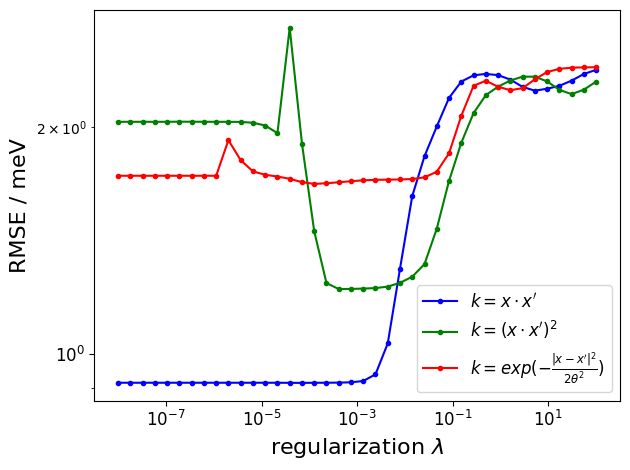

In [302]:
fontsize=16
fontsize_legend=12
fontsize_ticks=12
plt.loglog(lamdas, err_z1, 'b.-', label=label_z1)
plt.loglog(lamdas, err_z2, 'g.-', label=label_z2)
plt.loglog(lamdas, err_g, 'r.-', label=label_g)

plt.legend(fontsize=fontsize_legend)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.xlabel("regularization $\lambda$", fontsize=fontsize)
plt.ylabel("RMSE / meV", fontsize=fontsize)
plt.tight_layout()
plt.savefig("fig/soap-krr_RMSE-vs-regularization.pdf")

In [78]:
wg = np.linalg.lstsq( kgauss[itrain][:,itrain]    + 1e-4*np.eye(len(itrain)), y[itrain], rcond=None)[0]
yp_g = (kgauss[:,itrain]) @ wg

# Sparse model

In [22]:
# isparse = np.arange(ntot)[::7]
# nsparse = 8
# np.random.shuffle(isparse)
# isparse = isparse[-nsparse:]

In [89]:
isparse = itrain[::2]
nsparse = len(isparse)

In [90]:
len(isparse)

691

In [91]:
#plt.plot(lx[itrain], ly[itrain], 'k*')
#plt.plot(lx[isparse], ly[isparse], 'r+')

In [92]:
zeta = 2
KNM = (X[itrain]@X[isparse].T)**zeta
KMM = (X[isparse]@X[isparse].T)**zeta

In [93]:
lamda = 1e-8
wsparse = np.linalg.lstsq( KNM.T@KNM + lamda* KMM, KNM.T@y[itrain], rcond=None)[0]

In [94]:
ypred_sparse = ((X@X[isparse].T)**zeta) @ wsparse

In [95]:
print(np.sqrt(np.mean((y - ypred_sparse)[itest]**2)))

2.185568402120067


In [126]:
mae_sparse = sklearn.metrics.mean_absolute_error(y,ypred_sparse)
mae_sparse

0.9233535293356817

In [127]:
r2_sparse = sklearn.metrics.r2_score(y,ypred_sparse)
r2_sparse

0.5804418333762302

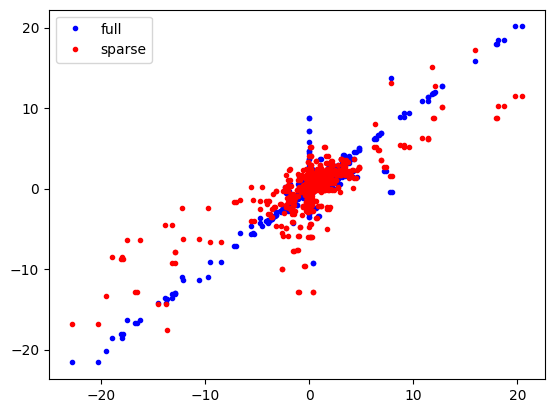

In [128]:
plt.plot(y,ypred_z2,'b.', label='full')
plt.plot(y,ypred_sparse,'r.', label='sparse')
plt.legend()

# (Make plots)

In [101]:
print(np.sqrt(np.mean((y - ypred_sparse)[itest]**2)))
np.sqrt(np.mean((y - ypred_sparse)[itest]**2)/np.mean((y)[itest]**2))

2.185568402120067


0.9104223724204

(0.008, 8)

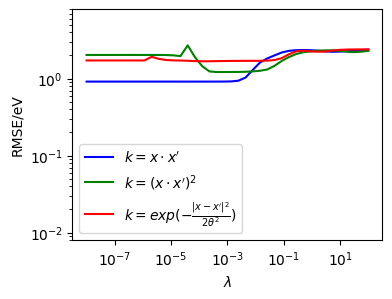

In [213]:
fig,ax = plt.subplots(figsize = (4,3))
ax.loglog(lamdas, err_z1, label=label_z1, c='b')
ax.loglog(lamdas, err_z2, label=label_z2, c='g')
ax.loglog(lamdas, err_g, label=label_g, c='r')
ax.legend()
ax.set_xlabel("$\lambda$")
ax.set_ylabel("RMSE/eV")
ax.set_ylim(8e-3,8)
# fig.savefig("h2o-reg.svg")
# fig.savefig("h2o-reg.pdf")

# Hyperparam surface visualization

Plot for Deringer2021 Figure 9 (b). 2D hyperparam landscape for gaussian kernel for params regularization, kernel length scale. record RMSE for every data point and plot on 2D map.

In [279]:
reglist = np.geomspace(1e-9, 1, 25)
thetalist = np.geomspace(1e-2, 1e2, 25)
nrm = (X**2).sum(axis=1)
kernel = X @ X.T

In [280]:
ert = []
reglist_discard = []
thetalist_discard = []
for ilamda, lamda in enumerate(tqdm(reglist)):
    et = []
    for it, t in enumerate(tqdm(thetalist)):
        kt = np.exp(-(np.add.outer(nrm,nrm) - 2*XXT)*0.5/t**2)
        #marg = kt.sum(axis=1);
        #kt += marg.sum()/len(marg)**2 - np.add.outer(marg,marg)/len(marg)
        try:
            wt = np.linalg.lstsq( kt[itrain][:,itrain]    + lamda**2*np.eye(len(itrain)), y[itrain], rcond=None)[0]
            yp_t = (kt[:,itrain]) @ wt
            et.append([lamda, t, np.sqrt(np.mean((yp_t - y)[itest]**2))])
        except np.linalg.LinAlgError as err: 
            # error message: "LinAlgError: SVD did not converge in Linear Least Squares"
            print(f"{err} for {lamda=}, {t=}. Discard.")
            reglist_discard.append(ilamda)
            thetalist_discard.append(it)
    if ilamda not in reglist_discard:
        ert.append(et)
# discard
reglist = np.delete(reglist, reglist_discard)
thetalist = np.delete(thetalist, thetalist_discard)

ert = np.asarray(ert)
ert = np.delete(ert, thetalist_discard, axis=1)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

SVD did not converge in Linear Least Squares for r=0.00017782794100389227, t=0.01. Discard.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [288]:
ert = np.delete(ert, thetalist_discard, axis=1)

In [109]:
# # doesn't finish with full X, try with sparse X
# X_sparse = X[isparse]
# reglist = np.geomspace(1e-9, 1, 100)
# thetalist = np.geomspace(1e-2, 1e2, 100)
# nrm = (X_sparse**2).sum(axis=1)
# kernel = X_sparse@X_sparse.T

In [ ]:
# ert = []
# for lamda in reglist:
#     et = []
#     for t in thetalist:
#         kt = np.exp(-(np.add.outer(nrm,nrm) - 2*X_sparse@X_sparse.T)*0.5/t**2)
#         #marg = kt.sum(axis=1);
#         #kt += marg.sum()/len(marg)**2 - np.add.outer(marg,marg)/len(marg)
#         wt = np.linalg.lstsq( kt[isparse][:,isparse]    + lamda**2*np.eye(len(isparse)), y[isparse], rcond=None)[0]
#         yp_t = (kt[:,isparse]) @ wt
#         et.append([lamda, t, np.sqrt(np.mean((yp_t - y)[itest]**2))])
#     ert.append(et)
# ert = np.asarray(ert)

In [281]:
def rasterize(cf):
    for c in cf.collections:
        c.set_rasterized(True)
    return cf

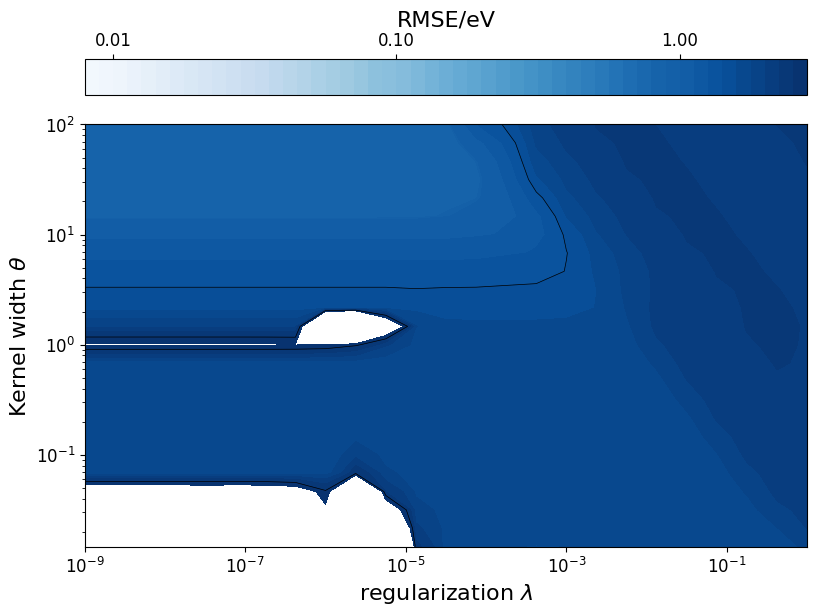

In [297]:
fontsize=16
fontsize_legend=12
fontsize_ticks=12

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize = (8,6))
norm = mpl.colors.LogNorm(vmin=8e-3, vmax=3)
levs= [0.01, 0.1,1,10]
l2 =  mpl.ticker.LogLocator(10,subs=np.geomspace(1,9.9,20)).tick_values(1e-2,1)
l2 = l2[((l2>=0.008) & (l2<3))]
cmap='Blues'
ZS = ert[:,:,2].T
pcm1 = rasterize(ax.contourf(reglist, thetalist, ZS, cmap=cmap, norm=norm,  levels=l2))
ax.contour(reglist, thetalist, ZS, colors='k', linewidths=0.5, norm=norm, levels=l2[::5])
ax.set_ylabel(r"Kernel width $\theta$", fontsize=fontsize)
ax.set_xlabel("regularization $\lambda$", fontsize=fontsize)
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax.tick_params(axis='both', which='minor', labelsize=0.8*fontsize_ticks)
#ax.set_xlim(0.695,0.905)
#ax.set_ylim(-0.105,0.105)
#for a, t in zip(ax, [r"$k=x\cdot x'$",r"$k=(x\cdot x')^2)$",r"$k=exp(-|x-x'|^2/\theta)$"]):
#    a.set_title(t,position=(0.97,0.9), 
#                fontsize=9, bbox=dict(facecolor='white', alpha=0.8, pad=1),pad=0,
#               ha='right', va='top')

# ax.plot([1e-8], [0.1], 'rx', markersize=10)
# ax.plot([1e-8], [1.0], 'rx', markersize=10)

cbar = fig.colorbar(pcm1, ax=ax, label='RMSE/eV', 
             norm=norm, cmap=cmap, location='top', ticks=levs)
cbar.ax.tick_params(labelsize=fontsize_ticks) 
cbar.set_label('RMSE/eV', fontsize=fontsize)
fig.set_constrained_layout_pads(w_pad=1./72., h_pad=1./72.,
        hspace=0., wspace=0.)

fig.savefig("fig/soap-krr_rmse-vs-.pdf")

Note: Compare to Deringer2021 Figure 9 b) (respectively figure in [original notebook](https://github.com/gabor1/chemrev-gpr/blob/main/water/water.ipynb)). This plot here looks odd. The surface should be smooth.